# Barotropic Model #

Here will will use pyqg to reproduce the results of the paper: <br />
J. C. Mcwilliams (1984). The emergence of isolated coherent vortices in turbulent flow. Journal of Fluid Mechanics, 146, pp 21-43 [doi:10.1017/S0022112084001750](http://dx.doi.org/10.1017/S0022112084001750)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyqg

McWilliams performed freely-evolving 2D turbulence ($R_d = \infty$, $\beta =0$) experiments on a $2\pi\times 2\pi$ periodic box.

In [2]:
# create the model object
m = pyqg.BTModel(L=2.*np.pi, nx=256, 
                 beta=0., H=1., rek=0., rd=None,
                 tmax=40, dt=0.001, taveint=1,
                 ntd=4)
# in this example we used ntd=4, four threads
# if your machine has more (or fewer) cores available, you could try changing it

INFO:  Logger initialized
INFO:  Kernel initialized


## Initial condition
The initial condition is random, with a prescribed spectrum
$$
|\hat{\psi}|^2 = A \,\kappa^{-1}\left[1 + \left(\frac{\kappa}{6}\right)^4\right]^{-1}\,,
$$
where $\kappa$ is the wavenumber magnitude. The constant A is determined so that the initial energy is $KE = 0.5$.

In [3]:
# generate McWilliams 84 IC condition

fk = m.wv != 0
ckappa = np.zeros_like(m.wv2)
ckappa[fk] = np.sqrt( m.wv2[fk]*(1. + (m.wv2[fk]/36.)**2) )**-1

nhx,nhy = m.wv2.shape

Pi_hat = np.random.randn(nhx,nhy)*ckappa +1j*np.random.randn(nhx,nhy)*ckappa

Pi = m.ifft( Pi_hat[np.newaxis,:,:] )
Pi = Pi - Pi.mean()
Pi_hat = m.fft( Pi )
KEaux = m.spec_var( m.wv*Pi_hat )

pih = ( Pi_hat/np.sqrt(KEaux) )
qih = -m.wv2*pih
qi = m.ifft(qih)

In [4]:
# initialize the model with that initial condition
m.set_q(qi)

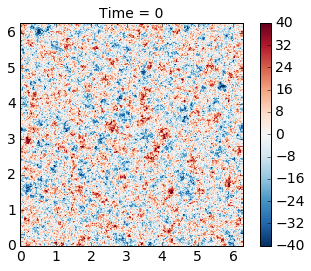

In [5]:
# define a quick function for plotting and visualize the initial condition
def plot_q(m, qmax=40):
    fig, ax = plt.subplots()
    pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
    pc.set_clim([-qmax, qmax])
    ax.set_xlim([0, 2*np.pi])
    ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    plt.title('Time = %g' % m.t)
    plt.show()

plot_q(m)

## Runing the model

Here we demonstrate how to use the ``run_with_snapshots`` feature to periodically stop the model and perform some action (in this case, visualization).

INFO: Step: 1000, Time: 1.00e+00, KE: 4.96e-01, CFL: 0.111
INFO: Step: 2000, Time: 2.00e+00, KE: 4.95e-01, CFL: 0.108
INFO: Step: 3000, Time: 3.00e+00, KE: 4.94e-01, CFL: 0.118
INFO: Step: 4000, Time: 4.00e+00, KE: 4.93e-01, CFL: 0.129
INFO: Step: 5000, Time: 5.00e+00, KE: 4.93e-01, CFL: 0.117
INFO: Step: 6000, Time: 6.00e+00, KE: 4.93e-01, CFL: 0.111
INFO: Step: 7000, Time: 7.00e+00, KE: 4.92e-01, CFL: 0.094
INFO: Step: 8000, Time: 8.00e+00, KE: 4.92e-01, CFL: 0.098
INFO: Step: 9000, Time: 9.00e+00, KE: 4.92e-01, CFL: 0.106
INFO: Step: 10000, Time: 1.00e+01, KE: 4.92e-01, CFL: 0.122


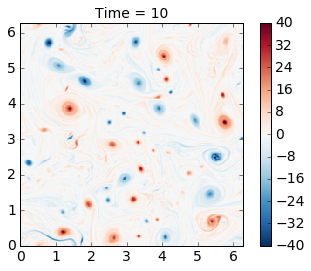

INFO: Step: 11000, Time: 1.10e+01, KE: 4.92e-01, CFL: 0.121
INFO: Step: 12000, Time: 1.20e+01, KE: 4.92e-01, CFL: 0.129
INFO: Step: 13000, Time: 1.30e+01, KE: 4.92e-01, CFL: 0.099
INFO: Step: 14000, Time: 1.40e+01, KE: 4.92e-01, CFL: 0.111
INFO: Step: 15000, Time: 1.50e+01, KE: 4.92e-01, CFL: 0.112
INFO: Step: 16000, Time: 1.60e+01, KE: 4.92e-01, CFL: 0.100
INFO: Step: 17000, Time: 1.70e+01, KE: 4.92e-01, CFL: 0.104
INFO: Step: 18000, Time: 1.80e+01, KE: 4.92e-01, CFL: 0.104
INFO: Step: 19000, Time: 1.90e+01, KE: 4.92e-01, CFL: 0.108
INFO: Step: 20000, Time: 2.00e+01, KE: 4.92e-01, CFL: 0.126


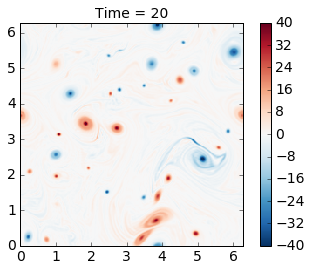

INFO: Step: 21000, Time: 2.10e+01, KE: 4.92e-01, CFL: 0.141
INFO: Step: 22000, Time: 2.20e+01, KE: 4.92e-01, CFL: 0.136
INFO: Step: 23000, Time: 2.30e+01, KE: 4.92e-01, CFL: 0.142
INFO: Step: 24000, Time: 2.40e+01, KE: 4.92e-01, CFL: 0.125
INFO: Step: 25000, Time: 2.50e+01, KE: 4.92e-01, CFL: 0.126
INFO: Step: 26000, Time: 2.60e+01, KE: 4.92e-01, CFL: 0.122
INFO: Step: 27000, Time: 2.70e+01, KE: 4.92e-01, CFL: 0.106
INFO: Step: 28000, Time: 2.80e+01, KE: 4.92e-01, CFL: 0.112
INFO: Step: 29000, Time: 2.90e+01, KE: 4.92e-01, CFL: 0.120
INFO: Step: 30000, Time: 3.00e+01, KE: 4.92e-01, CFL: 0.110


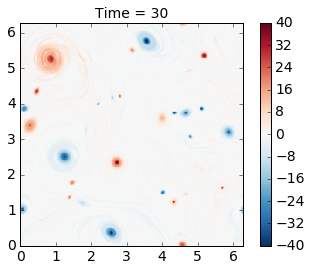

INFO: Step: 31000, Time: 3.10e+01, KE: 4.92e-01, CFL: 0.111
INFO: Step: 32000, Time: 3.20e+01, KE: 4.92e-01, CFL: 0.110
INFO: Step: 33000, Time: 3.30e+01, KE: 4.92e-01, CFL: 0.107
INFO: Step: 34000, Time: 3.40e+01, KE: 4.92e-01, CFL: 0.115
INFO: Step: 35000, Time: 3.50e+01, KE: 4.92e-01, CFL: 0.117
INFO: Step: 36000, Time: 3.60e+01, KE: 4.92e-01, CFL: 0.111
INFO: Step: 37000, Time: 3.70e+01, KE: 4.92e-01, CFL: 0.124
INFO: Step: 38000, Time: 3.80e+01, KE: 4.92e-01, CFL: 0.123
INFO: Step: 39000, Time: 3.90e+01, KE: 4.92e-01, CFL: 0.121
INFO: Step: 40000, Time: 4.00e+01, KE: 4.92e-01, CFL: 0.126


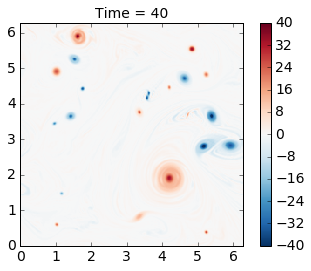

In [6]:
for _ in m.run_with_snapshots(tsnapstart=0, tsnapint=10):
    plot_q(m)

The genius of McWilliams (1984) was that he showed that the initial random vorticity field organizes itself into strong coherent vortices. This is true in significant part of the parameter space. This was previously suspected but unproven, mainly because people did not have computer resources to run the simulation long enough. Thirty years later we can perform such simulations in a couple of minutes on a laptop!

Also, note that the energy is nearly conserved, as it should be, and this is a nice test of the model.

## Plotting spectra

In [7]:
energy = m.get_diagnostic('KEspec')
enstrophy = m.get_diagnostic('Ensspec')

In [8]:
# this makes it easy to calculate an isotropic spectrum
from pyqg import diagnostic_tools as tools
kr, energy_iso = tools.calc_ispec(m,energy.squeeze())
_, enstrophy_iso = tools.calc_ispec(m,enstrophy.squeeze())

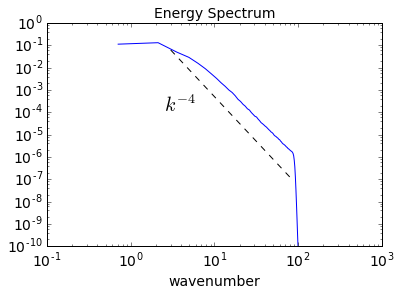

In [9]:
ks = np.array([3.,80])
es = 5*ks**-4
plt.loglog(kr,energy_iso)
plt.loglog(ks,es,'k--')
plt.text(2.5,.0001,r'$k^{-4}$',fontsize=20)
plt.ylim(1.e-10,1.e0)
plt.xlabel('wavenumber')
plt.title('Energy Spectrum')

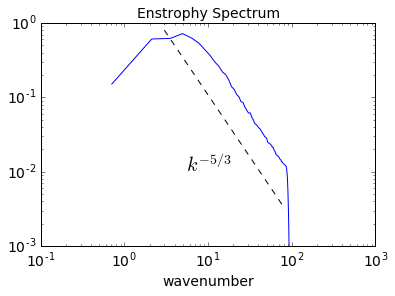

In [10]:
ks = np.array([3.,80])
es = 5*ks**(-5./3)
plt.loglog(kr,enstrophy_iso)
plt.loglog(ks,es,'k--')
plt.text(5.5,.01,r'$k^{-5/3}$',fontsize=20)
plt.ylim(1.e-3,1.e0)
plt.xlabel('wavenumber')
plt.title('Enstrophy Spectrum')

# Adding topography

pyqg supports bottom topography, which can be easily set by the user. Here we extend the example above to include a Guassian topographic bump.

In [26]:
mtopo = pyqg.BTModel(L=2.*np.pi, nx=256, 
                 beta=0., H=1., rek=0., rd=None,
                 tmax=40, dt=0.001, taveint=1, f=1.,
                 ntd=4)

INFO:  Logger initialized
INFO:  Kernel initialized


In [27]:
mtopo.set_q(qi)

In [28]:
# set topography
R2 = 1.
etab = 10*np.exp( -(m.x-np.pi)**2/R2  -(m.y-np.pi)**2/R2  )
etab = etab - etab.mean()
mtopo.set_h(etab)

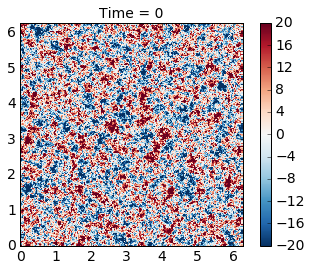

In [29]:
# define a quick function
def plot_q(mtopo, qmax=20):
    fig, ax = plt.subplots()
    pc = ax.pcolormesh(mtopo.x,mtopo.y,mtopo.q.squeeze(), cmap='RdBu_r')
    pc.set_clim([-qmax,qmax])
    ax.set_xlim([0, 2*np.pi])
    ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    plt.title('Time = %g' % mtopo.t)
    plt.show()

plot_q(mtopo)

INFO: Step: 1000, Time: 1.00e+00, KE: 4.96e-01, CFL: 0.109
INFO: Step: 2000, Time: 2.00e+00, KE: 4.95e-01, CFL: 0.096
INFO: Step: 3000, Time: 3.00e+00, KE: 4.94e-01, CFL: 0.117
INFO: Step: 4000, Time: 4.00e+00, KE: 4.93e-01, CFL: 0.095
INFO: Step: 5000, Time: 5.00e+00, KE: 4.93e-01, CFL: 0.091
INFO: Step: 6000, Time: 6.00e+00, KE: 4.93e-01, CFL: 0.094
INFO: Step: 7000, Time: 7.00e+00, KE: 4.92e-01, CFL: 0.098
INFO: Step: 8000, Time: 8.00e+00, KE: 4.92e-01, CFL: 0.091
INFO: Step: 9000, Time: 9.00e+00, KE: 4.92e-01, CFL: 0.121
INFO: Step: 10000, Time: 1.00e+01, KE: 4.92e-01, CFL: 0.113


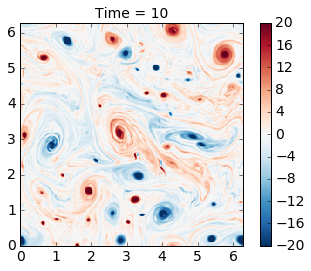

INFO: Step: 11000, Time: 1.10e+01, KE: 4.92e-01, CFL: 0.110
INFO: Step: 12000, Time: 1.20e+01, KE: 4.92e-01, CFL: 0.108
INFO: Step: 13000, Time: 1.30e+01, KE: 4.92e-01, CFL: 0.120
INFO: Step: 14000, Time: 1.40e+01, KE: 4.92e-01, CFL: 0.105
INFO: Step: 15000, Time: 1.50e+01, KE: 4.92e-01, CFL: 0.119
INFO: Step: 16000, Time: 1.60e+01, KE: 4.92e-01, CFL: 0.133
INFO: Step: 17000, Time: 1.70e+01, KE: 4.92e-01, CFL: 0.124
INFO: Step: 18000, Time: 1.80e+01, KE: 4.92e-01, CFL: 0.097
INFO: Step: 19000, Time: 1.90e+01, KE: 4.92e-01, CFL: 0.103
INFO: Step: 20000, Time: 2.00e+01, KE: 4.92e-01, CFL: 0.114


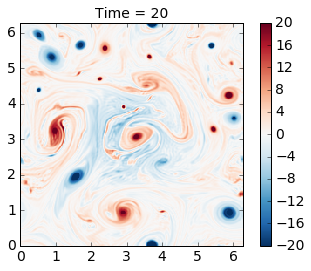

INFO: Step: 21000, Time: 2.10e+01, KE: 4.92e-01, CFL: 0.116
INFO: Step: 22000, Time: 2.20e+01, KE: 4.92e-01, CFL: 0.126
INFO: Step: 23000, Time: 2.30e+01, KE: 4.92e-01, CFL: 0.108
INFO: Step: 24000, Time: 2.40e+01, KE: 4.92e-01, CFL: 0.128
INFO: Step: 25000, Time: 2.50e+01, KE: 4.92e-01, CFL: 0.137
INFO: Step: 26000, Time: 2.60e+01, KE: 4.91e-01, CFL: 0.136
INFO: Step: 27000, Time: 2.70e+01, KE: 4.91e-01, CFL: 0.126
INFO: Step: 28000, Time: 2.80e+01, KE: 4.91e-01, CFL: 0.128
INFO: Step: 29000, Time: 2.90e+01, KE: 4.91e-01, CFL: 0.129
INFO: Step: 30000, Time: 3.00e+01, KE: 4.91e-01, CFL: 0.136


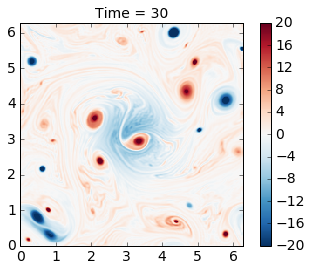

INFO: Step: 31000, Time: 3.10e+01, KE: 4.91e-01, CFL: 0.136
INFO: Step: 32000, Time: 3.20e+01, KE: 4.91e-01, CFL: 0.136
INFO: Step: 33000, Time: 3.30e+01, KE: 4.91e-01, CFL: 0.131
INFO: Step: 34000, Time: 3.40e+01, KE: 4.91e-01, CFL: 0.126
INFO: Step: 35000, Time: 3.50e+01, KE: 4.91e-01, CFL: 0.126
INFO: Step: 36000, Time: 3.60e+01, KE: 4.91e-01, CFL: 0.108
INFO: Step: 37000, Time: 3.70e+01, KE: 4.91e-01, CFL: 0.133
INFO: Step: 38000, Time: 3.80e+01, KE: 4.91e-01, CFL: 0.131
INFO: Step: 39000, Time: 3.90e+01, KE: 4.91e-01, CFL: 0.112
INFO: Step: 40000, Time: 4.00e+01, KE: 4.91e-01, CFL: 0.143


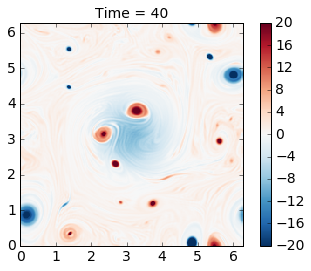

In [30]:
for _ in mtopo.run_with_snapshots(tsnapstart=0, tsnapint=10):
    plot_q(mtopo)

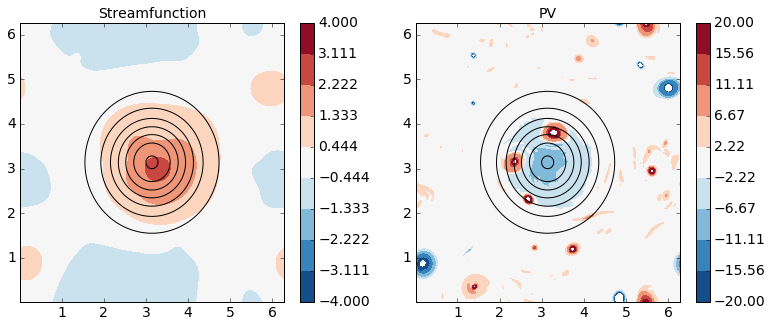

In [31]:
fig = plt.figure(figsize=(13,5))
plt.subplot(121)
pc = plt.contourf(mtopo.x,mtopo.y,np.fft.irfft2(mtopo.ph[0]),np.linspace(-4,4,10),cmap='RdBu_r')
plt.contour(mtopo.x,mtopo.y,etab,colors='k')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi]);
#pc.set_clim([-40,40])
plt.colorbar(pc)
ax.set_aspect(1)
plt.title('Streamfunction')

plt.subplot(122)
pc = plt.contourf(mtopo.x,mtopo.y,mtopo.q[0],np.linspace(-20,20,10),cmap='RdBu_r')
plt.contour(mtopo.x,mtopo.y,etab,colors='k')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi]);
#pc.set_clim([-40,40])
plt.colorbar(pc)
ax.set_aspect(1)
plt.title('PV')